Albocycline
===========

<!--<img title="https://pubchem.ncbi.nlm.nih.gov" src="https://pubchem.ncbi.nlm.nih.gov/image/imagefly.cgi?cid=6440973&width=500&height=500" align="center" height="400" width="400">-->


<hr style="height:2.5px">

<h2 style="align: center;font-size: 12pt;">Summary:</h2> Albocycline is a macrolactone isolated from Streptomyces maizeus.  This macrolactone has recently been identified as a promising lead antibiotic candidate for the treatment of both vancomycin-resistant S. aureus (VRSA) and MRSA.<br>
In our previous example we showed in detail how to calculate the consistency of theoretical modeling with experiment. The user gained insight on how to run `biceps` calculations in full. In this example, we will repeat the process parallelizing lambda values with `multiprocessing`.</h2>



**To convert this Jupyter Notebook into a script use the following command:**

```
$ jupyter nbconvert --to python albocycline.ipynb
```

<hr style="height:2.5px">

In [1]:
import numpy as np
import pandas as pd
import biceps

BICePs - Bayesian Inference of Conformational Populations, Version 2.0


In [2]:
####### Data and Output Directories #######
print(f"Possible input data extensions: {biceps.toolbox.list_possible_extensions()}")
energies = np.loadtxt('albocycline/albocycline_QMenergies.dat')*627.509  # convert from hartrees to kcal/mol
energies = energies/0.5959   # convert to reduced free energies F = f/kT
energies -= energies.min()  # set ground state to zero, just in case
dataFiles = 'albocycline/new_J_NOE'
input_data = biceps.toolbox.sort_data(dataFiles)
print(f"Input data: {biceps.toolbox.list_extensions(input_data)}")
outdir = 'results'
biceps.toolbox.mkdir(outdir)

Possible input data extensions: ['H', 'Ca', 'N', 'J', 'noe', 'pf']
Input data: ['J', 'noe']


In [3]:
####### Parameters #######
nsteps=10000000
print(f"nSteps of sampling: {nsteps}")
n_lambdas = 3
lambda_values = np.linspace(0.0, 1.0, n_lambdas)
parameters = [
        {"ref": 'uniform', "sigma": (0.05, 20.0, 1.02)},
        {"ref": 'exp', "sigma": (0.05, 5.0, 1.02), "gamma": (0.2, 5.0, 1.01)}
        ]
pd.DataFrame(parameters)

nSteps of sampling: 10000000


,ref,sigma,gamma
0,uniform,"(0.05, 20.0, 1.02)",NaN
1,exp,"(0.05, 5.0, 1.02)","(0.2, 5.0, 1.01)"


In [4]:
####### Multiprocessing Lambda values #######
@biceps.multiprocess(iterable=lambda_values)
def mp_lambdas(lam):
    ensemble = biceps.Ensemble(lam, energies)
    ensemble.initialize_restraints(input_data, parameters)
    sampler = biceps.PosteriorSampler(ensemble.to_list())
    sampler.sample(nsteps=nsteps, verbose=False)
    sampler.traj.process_results(outdir+'/traj_lambda%2.2f.npz'%(lam))
    filename = outdir+'/sampler_lambda%2.2f.pkl'%(lam)
    biceps.toolbox.save_object(sampler, filename)

Number of CPUs: 6
Number of processes: 3

Accepted 71.20017 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.66669 31.51476 31.51476  7.01872] % 


Accepted 72.05754 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.66657 31.70527 31.70527  7.6857 ] % 


Accepted 66.90749 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.67527 31.70407 31.70407  2.52815] % 



Loading results/traj_lambda0.00.npz ...
Loading results/traj_lambda0.50.npz ...
Loading results/traj_lambda1.00.npz ...
not all state sampled, these states [ 5  7  9 11 15 16 25 27 40 42 48 77 81 87 95 98] are not sampled
Loading results/sampler_lambda0.00.pkl ...
Loading results/sampler_lambda0.50.pkl ...
Loading results/sampler_lambda1.00.pkl ...
lam = [0.0, 0.5, 1.0]
nstates 100
Writing results/BS.dat...
...Done.
Writing results/populations.dat...
...Done.
Top 10 states: [59, 65, 91, 80, 37, 39, 38, 92, 46, 85]
Top 10 populations: [0.01979935 0.02072878 0.03187067 0.04095707 0.05693156 0.07443944
 0.08917493 0.1361757  0.20587539 0.2118544 ]


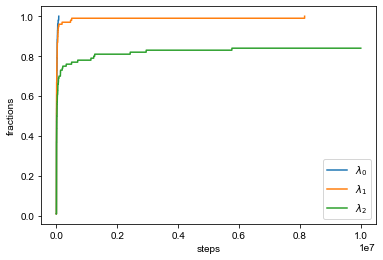

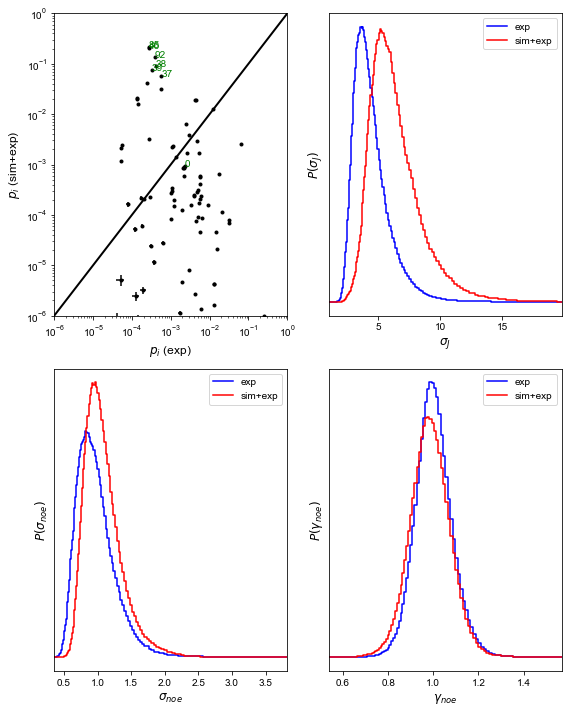

In [5]:
####### Posterior Analysis #######
%matplotlib inline
A = biceps.Analysis(outdir, nstates=len(energies))
A.plot()

<h6 style="align: justify;font-size: 12pt"># <span style="color:red;">NOTE</span>: The following cell is for pretty notebook rendering</h6>

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../../theme.css", "r").read()
    return HTML(styles)
css_styling()